In [17]:
from src.geojson import build_geojson_feature_collection
import numpy as np
from src.cluster_stats import Stats
from src.darwin_core_aggregations import DarwinCoreAggregations
from src.render import plot_clusters
from src.geojson import build_geojson_feature_collection
import logging
from run import cluster
from src import cluster_index
import polars as pl


In [18]:
# Inputs
input_file = "data-north-america-us-ca-mx.csv"
geohash_precision = 3
show_dendrogram = True
log_file = "log.txt"
output_file = "output.geojson"
num_clusters = 8
use_cache = False
plot = True

In [19]:
# set up logging
logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)


In [20]:
darwin_core_aggregations = DarwinCoreAggregations.build(
    input_file, geohash_precision
)

In [21]:
darwin_core_aggregations.unfiltered_taxon_counts

geohash,kingdom,rank,name,count
str,enum,enum,str,u32
"""9em""","""Animalia""","""genus""","""Archilestris""",11
"""9em""","""Animalia""","""family""","""Asilidae""",19
"""9em""","""Animalia""","""family""","""Bombyliidae""",1
"""9em""","""Animalia""","""family""","""Nemestrinidae""",1
"""9em""","""Animalia""","""species""","""Clogmia albipunctatus""",4
…,…,…,…,…
"""fkd""","""Animalia""","""class""","""Insecta""",1
"""fkd""","""Animalia""","""genus""","""Sericomyia""",1
"""fkd""","""Animalia""","""phylum""","""Arthropoda""",1


In [22]:
darwin_core_aggregations.taxon_counts

geohash,kingdom,species,count
str,enum,str,u32
"""9em""","""Animalia""","""Clogmia albipunctatus""",4
"""9em""","""Animalia""","""Lepiselaga crassipes""",2
"""9em""","""Animalia""","""Mydas rubidapex""",1
"""9em""","""Animalia""","""Palpada pusilla""",1
"""9em""","""Animalia""","""Senobasis annulata""",1
…,…,…,…
"""fd6""","""Animalia""","""Neoleria inscripta""",1
"""fd9""","""Animalia""","""Hypoderma tarandi""",1
"""fdh""","""Animalia""","""Eristalis tenax""",1


/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/sklearn/decomposition/_incremental_pca.py:376: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


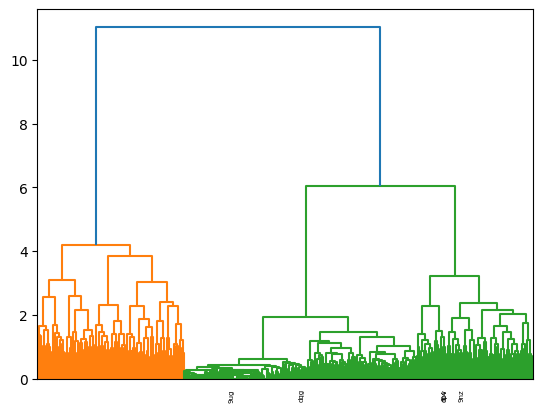

In [23]:

clusters = cluster.run(
    darwin_core_aggregations,
    num_clusters,
    show_dendrogram,
    use_cache,
)

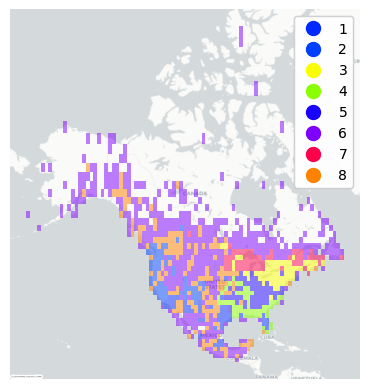

In [24]:
# Find the top averages of taxon
all_stats = Stats.build(darwin_core_aggregations)

cluster_colors = {}
for cluster, geohashes in cluster_index.iter_clusters_and_geohashes(clusters):
    cluster_colors[cluster] = cluster_index.determine_color_for_cluster(
        clusters, cluster, darwin_core_aggregations
    )

feature_collection = build_geojson_feature_collection(
    (
        cluster,
        [i for i in geohashes if not i.startswith("z")],  # Exclude the Aleutian Islands
        cluster_colors[cluster],
    )
    for cluster, geohashes in cluster_index.iter_clusters_and_geohashes(clusters)
)

# print_results(darwin_core_aggregations, all_stats, cluster_dataframe)

from run import write_geojson
write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

# write_geojson(feature_collection, args.output_file)

In [25]:
from src import cli_output
cluster_id = 1
geohashes = cluster_index.geohashes_for_cluster(clusters, cluster_id)
cli_output.print_cluster_stats(cluster_id, geohashes, darwin_core_aggregations, all_stats)


----------
cluster 1 (count: 53)
Allograpta obliqua (Animalia):
  - Percentage difference: +143.60%
  - Proportion: 4.00%
  - Count: 5513
Plecia nearctica (Animalia):
  - Percentage difference: +280.23%
  - Proportion: 2.62%
  - Count: 3621
Eupeodes volucris (Animalia):
  - Percentage difference: +153.05%
  - Proportion: 2.44%
  - Count: 3372
Hermetia illucens (Animalia):
  - Percentage difference: +90.81%
  - Proportion: 2.22%
  - Count: 3064


In [26]:
stats_for_clusters = {
    cluster: Stats.build(
        darwin_core_aggregations,
        geohash_filter=geohashes,
    )
    for cluster, geohashes in cluster_index.iter_clusters_and_geohashes(clusters)
}
stats_for_clusters[2].taxon.filter(pl.col("species") == "Weigela florida").collect()


kingdom,species,count,average
enum,str,u32,f64


In [28]:
[
    {
        "cluster": cluster,
        "waterfowl": stats.waterfowl_count(),
        "aves": stats.aves_count(),
        # "ratio": stats.waterfowl_count() / stats.aves_count(),
    }
    for cluster, stats in stats_for_clusters.items()
]



[{'cluster': 1, 'waterfowl': 0, 'aves': 0},
 {'cluster': 2, 'waterfowl': 0, 'aves': 0},
 {'cluster': 3, 'waterfowl': 0, 'aves': 0},
 {'cluster': 4, 'waterfowl': 0, 'aves': 0},
 {'cluster': 5, 'waterfowl': 0, 'aves': 0},
 {'cluster': 6, 'waterfowl': 0, 'aves': 0},
 {'cluster': 7, 'waterfowl': 0, 'aves': 0},
 {'cluster': 8, 'waterfowl': 0, 'aves': 0}]

In [29]:
from IPython.display import display, HTML

for cluster, geohashes in cluster_index.iter_clusters_and_geohashes(clusters):
    # Print cluster stats

    color = cluster_colors[cluster]
    html = f"<h1>Cluster {cluster}</h1>"
    html += f"<li>Color: <span style='color: {cluster_colors[cluster]};'>{cluster_colors[cluster]}</span></li>"
    stats = Stats.build(darwin_core_aggregations, geohash_filter=geohashes)

    for kingdom, species, count in (
        stats.taxon.sort(by="count", descending=True)
        .limit(10)
        .select(["kingdom", "species", "count"])
        .collect()
        .iter_rows(named=False)
    ):
        average = (
            stats.taxon.filter(
                pl.col("kingdom") == kingdom, pl.col("species") == species
            )
            .collect()
            .get_column("average")
            .item()
        )
        all_average = (
            all_stats.taxon.filter(
                pl.col("kingdom") == kingdom, pl.col("species") == species
            )
            .collect()
            .get_column("average")
            .item()
        )

        # If the difference between the average of the cluster and the average of all is greater than 20%, print it
        percent_diff = (average / all_average * 100) - 100
        if abs(percent_diff) > 20:
            # Print the percentage difference
            html += f"<h2>{species} ({kingdom}):</h2>"
            html += "<ul>"
            html += f"<li>Percentage difference: {'+' if percent_diff > 0 else ''}{percent_diff:.2f}%</li>"
            html += f"<li>Proportion: {average * 100:.2f}%</li>"
            html += f"<li>Count: {count}</li>"
            html += "</ul>"

    display(HTML(html))
